In [90]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel

# 1. 데이터 준비
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10 = CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(cifar10, batch_size=64, shuffle=True)


Files already downloaded and verified


In [91]:
for i, (images, labels) in enumerate(dataloader):
  print(images.shape)
  print(labels.shape)
  break

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [92]:

# CIFAR-10 클래스에 대한 간단한 텍스트 설명
class_descriptions = [
    "an airplane flying in the sky",
    "a car driving on the road",
    "a bird perched on a branch",
    "a cat sitting and looking at the camera",
    "a deer standing in a forest",
    "a dog wagging its tail",
    "a frog sitting near water",
    "a horse galloping in a field",
    "a ship sailing on the ocean",
    "a truck carrying cargo on a highway"
]

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. 모델 정의
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, 256)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.last_hidden_state[:, 0, :])

class ImageGenerator(nn.Module):
    def __init__(self):
        super(ImageGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(256, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# 3. 모델 초기화
text_encoder = TextEncoder()
image_generator = ImageGenerator()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 4. 손실 함수와 옵티마이저
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(text_encoder.parameters()) + list(image_generator.parameters()), lr=0.0002)

# 5. 학습 루프
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_encoder.to(device)
image_generator.to(device)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        descriptions = [classes[label] for label in labels]
        inputs = tokenizer(descriptions, padding=True, truncation=True, return_tensors="pt")

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        images = images.to(device)

        # 텍스트 인코딩
        text_features = text_encoder(input_ids, attention_mask)

        # 이미지 생성
        generated_images = image_generator(text_features)

        # 손실 계산 및 역전파
        loss = criterion(generated_images, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

print("Training finished!")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch [1/50], Step [1/782], Loss: 0.6632
Epoch [1/50], Step [101/782], Loss: 0.2577
Epoch [1/50], Step [201/782], Loss: 0.2566
Epoch [1/50], Step [301/782], Loss: 0.2641
Epoch [1/50], Step [401/782], Loss: 0.2288
Epoch [1/50], Step [501/782], Loss: 0.2520
Epoch [1/50], Step [601/782], Loss: 0.2360
Epoch [1/50], Step [701/782], Loss: 0.2524
Epoch [2/50], Step [1/782], Loss: 0.2525
Epoch [2/50], Step [101/782], Loss: 0.2535
Epoch [2/50], Step [201/782], Loss: 0.2266
Epoch [2/50], Step [301/782], Loss: 0.2540
Epoch [2/50], Step [401/782], Loss: 0.2567
Epoch [2/50], Step [501/782], Loss: 0.2211
Epoch [2/50], Step [601/782], Loss: 0.2650
Epoch [2/50], Step [701/782], Loss: 0.2733
Epoch [3/50], Step [1/782], Loss: 0.2627
Epoch [3/50], Step [101/782], Loss: 0.2928
Epoch [3/50], Step [201/782], Loss: 0.2316
Epoch [3/50], Step [301/782], Loss: 0.2613
Epoch [3/50], Step [401/782], Loss: 0.2474
Epoch [3/50], Step [501/782], Loss: 0.2540
Epoch [3/50], Step [601/782], Loss: 0.2390
Epoch [3/50], Ste

KeyboardInterrupt: 

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


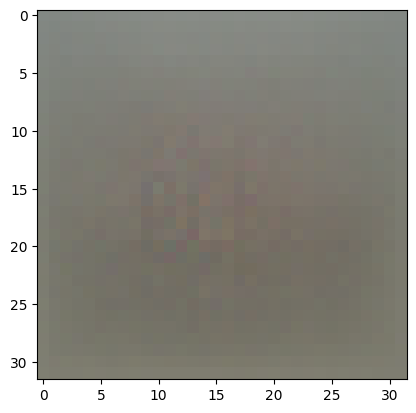

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


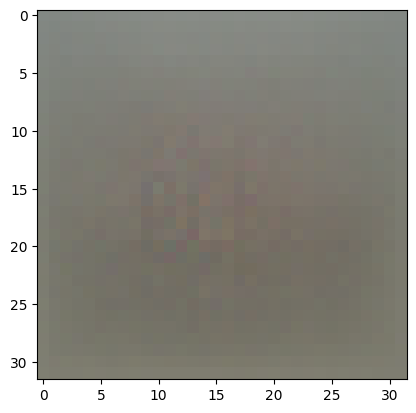

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


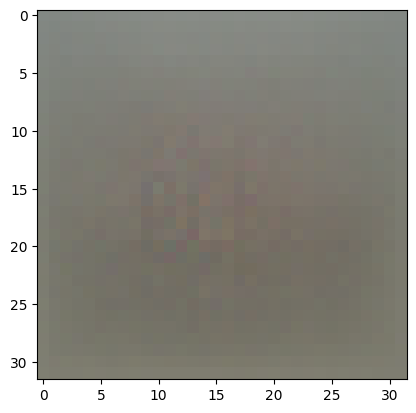

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


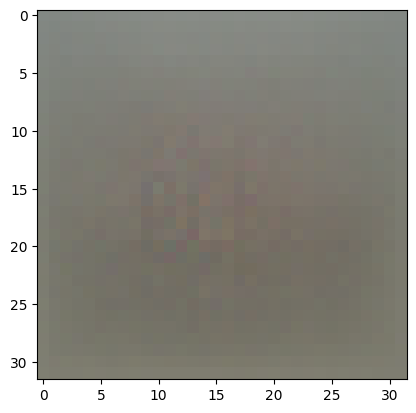

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


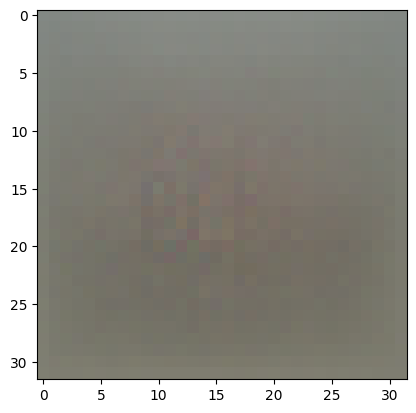

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


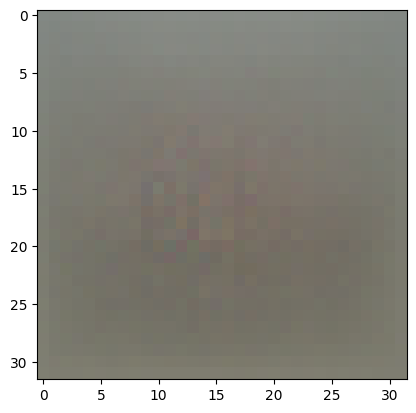

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


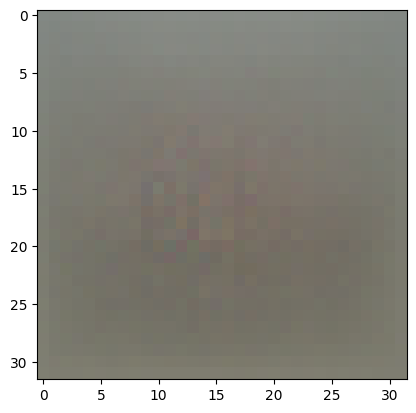

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


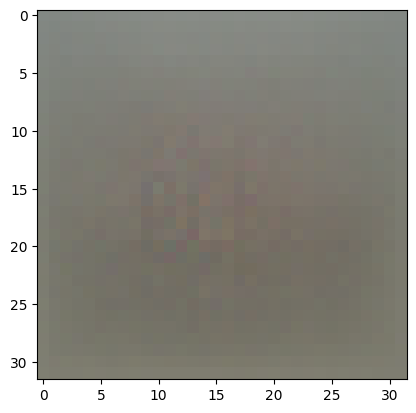

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


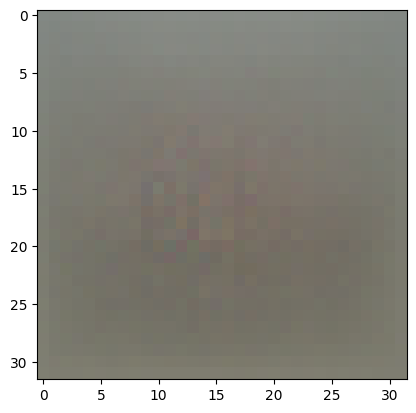

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
a
a
a
a
b
(32, 32, 3)


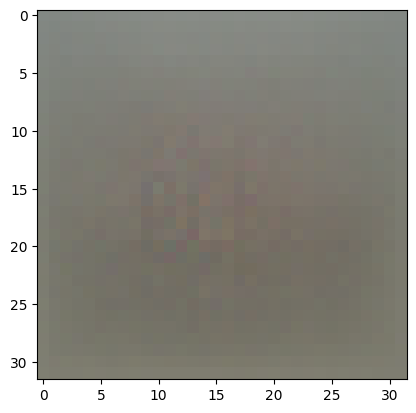

In [96]:
for descriptions in classes :
  inputs = tokenizer(descriptions, padding=True, truncation=True, return_tensors="pt")

  input_ids = inputs['input_ids'].to(device)
  attention_mask = inputs['attention_mask'].to(device)
  images = images.to(device)

          # 텍스트 인코딩
  text_features = text_encoder(input_ids, attention_mask)

          # 이미지 생성
  generated_images = image_generator(text_features)
  imshow(torchvision.utils.make_grid(generated_images.detach()))

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.functional import F

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [99]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [101]:
embed_size = 100
d_hidden_1 = 256
d_hidden_2 = 256
image_dim = 28*28
batch_size = 64
'''
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(d_noise, 256, kernel_size=8, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), d_noise, 1, 1)  # 입력 잡음 벡터를 (batch_size, d_noise, 1, 1) 형태로 변환
        x = self.generator(x)
        return x

    def forward(self, x):
        x = self.generator(x)
        return x
'''
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(embed_size, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [129]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=48, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=192, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(192)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.4)

        self.fc1 = nn.Linear(in_features=192*4*4, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x)))) #32*32
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x)))) #16*16
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))  #8*8

        x = x.view(-1, 192*4*4)

        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [130]:
'''
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(3*32*32, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 10),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        x = self.discriminator(x)
        return x
        '''

'\nclass Discriminator(nn.Module):\n    def __init__(self):\n        super(Discriminator, self).__init__()\n\n        self.discriminator = nn.Sequential(\n            nn.Linear(3*32*32, 1024),\n            nn.LeakyReLU(),\n            nn.Dropout(0.1),\n            nn.Linear(1024, 512),\n            nn.LeakyReLU(),\n            nn.Dropout(0.1),\n            nn.Linear(512, 128),\n            nn.LeakyReLU(),\n            nn.Dropout(0.1),\n            nn.Linear(128, 10),\n            nn.Sigmoid()\n        ).to(device)\n\n    def forward(self, x):\n        x = self.discriminator(x)\n        return x\n        '

In [131]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

disc = Discriminator().to(device)
gen = Generator().to(device)

lr = 3e-4


opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

step = 0

In [132]:
embeddings = nn.Embedding(num_embeddings=len(classes),
                               embedding_dim=100,
                               padding_idx=1)

In [154]:
fake_list = []
real_list = []

epochs = 30

for epoch in range(epochs):
    for batch_idx, (image, label) in enumerate(train_loader):
        #imgae -> (4,3,32,32)
        label.to(device)
        batch_size = image.shape[0]
        image = image.view(batch_size, 3, -1).to(device) #(4,3,1024)
        label_onehot = F.one_hot(label, num_classes=len(classes)).to(device) #(4,10)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        label_embedding = embeddings(label).to(device) #(4,100)
        fake = gen(label_embedding) #임베딩으로 이미지 생성 #(64,3,32,32)

        disc_real = disc(image.view(batch_size, 3, 32, 32)) # (4, 10)

        label_onehot = label_onehot.float()
        #print(disc_real[0])
        #print(label_onehot[0])
        lossD_real = criterion(disc_real.to(device), label_onehot.to(device))
        opt_disc.zero_grad()
        lossD_real.backward()
        opt_disc.step()

        disc_fake = disc(fake.view(batch_size, 3, 32, 32)) # (4, 10) => (40,)
        lossD_fake = criterion(disc_fake.to(device), (1-label_onehot))
        #print(disc_fake.shape)
        lossD_fake = lossD_fake/10

        lossD_fake.backward(retain_graph=True)
        opt_disc.step()
        opt_disc.zero_grad()
        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        opt_gen.zero_grad()
        output = disc(fake)
        lossG = criterion(output.to(device), label_onehot.to(device))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        opt_gen.zero_grad()
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] lossD_real: {lossD_real:.4f}, lossD_fake: {lossD_fake:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                #fake = gen(fake).reshape(-1, 3, 32, 32)
                data = image.reshape(-1, 3, 32, 32)

                fake_list.append(fake)
                real_list.append(data)
                step += 1

Epoch [0/50] lossD_real: 2.3205, lossD_fake: 2.1291, loss G: 2.3205
Epoch [1/50] lossD_real: 2.3987, lossD_fake: 2.1213, loss G: 2.3987
Epoch [2/50] lossD_real: 2.3362, lossD_fake: 2.1275, loss G: 2.3362
Epoch [3/50] lossD_real: 2.3987, lossD_fake: 2.1213, loss G: 2.3987
Epoch [4/50] lossD_real: 2.3362, lossD_fake: 2.1275, loss G: 2.3362
Epoch [5/50] lossD_real: 2.3674, lossD_fake: 2.1244, loss G: 2.3674
Epoch [6/50] lossD_real: 2.3518, lossD_fake: 2.1260, loss G: 2.3518
Epoch [7/50] lossD_real: 2.3830, lossD_fake: 2.1228, loss G: 2.3830
Epoch [8/50] lossD_real: 2.2893, lossD_fake: 2.1322, loss G: 2.2893
Epoch [9/50] lossD_real: 2.3049, lossD_fake: 2.1307, loss G: 2.3049
Epoch [10/50] lossD_real: 2.3049, lossD_fake: 2.1307, loss G: 2.3049
Epoch [11/50] lossD_real: 2.3205, lossD_fake: 2.1291, loss G: 2.3205
Epoch [12/50] lossD_real: 2.3830, lossD_fake: 2.1228, loss G: 2.3830
Epoch [13/50] lossD_real: 2.3830, lossD_fake: 2.1228, loss G: 2.3830
Epoch [14/50] lossD_real: 2.3674, lossD_fake

In [155]:
import torch
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

# 정규화 파라미터
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# 정규화 해제 변환 정의
def denormalize(tensor, mean, std):
    """
    텐서를 원래 이미지로 되돌리기 위해 정규화 해제하는 함수
    """

    # 텐서를 NumPy 배열로 변환
    tensor = tensor.clone().cpu()
    tensor = tensor * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

    # 텐서를 [0, 1] 범위로 클리핑
    tensor = torch.clamp(tensor, 0, 1)

    # 텐서를 NumPy 배열로 변환
    np_image = tensor.numpy().transpose(1, 2, 0)

    # NumPy 배열을 PIL 이미지로 변환
    return np_image

import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):

    npimg = denormalize(img, mean, std)  # unnormalize
    #npimg = img.cpu().numpy()
    plt.imshow(npimg)
    plt.show()

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])


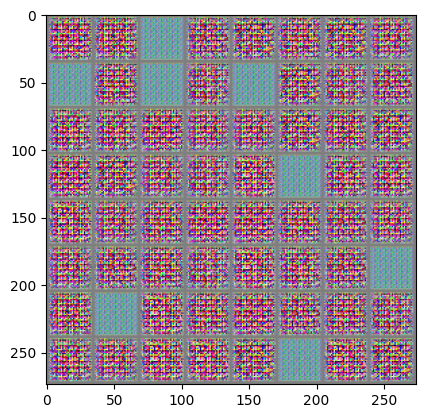

frog  bird  frog  ship  ship  frog  horse ship  car   car   ship  horse truck dog   frog  deer 


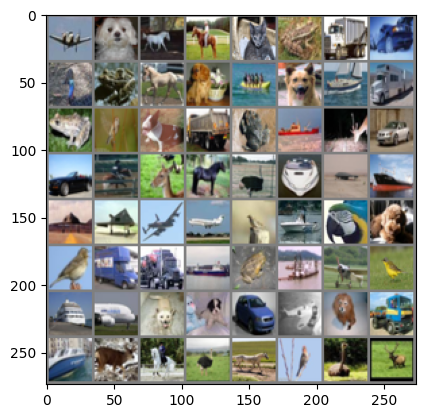

In [156]:
# 학습용 이미지를 무작위로 가져오기
#dataiter = iter(trainloader)
images = fake_list[-1]
print(type(images))
print(images.shape)
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
images = real_list[0]

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력


In [159]:
gen.eval()
test = embeddings(torch.tensor([3])).to(device)
print(test.shape)
out = gen(test)
print(out.shape)
disc.eval()
out = disc(out)
tensor_flat = out.view(-1)

# 최댓값의 인덱스 찾기
index = torch.argmax(tensor_flat)

print("최댓값의 인덱스:", index.item())

torch.Size([1, 100])
torch.Size([1, 3, 32, 32])
최댓값의 인덱스: 0


In [160]:
tensor_flat

tensor([1.0000e+00, 1.3129e-32, 5.3852e-35, 4.4595e-34, 1.6842e-32, 4.7561e-33,
        3.8055e-32, 3.8852e-33, 2.2070e-33, 1.6137e-33], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [137]:
result = disc(fake_list[90])
result[1]

IndexError: list index out of range

In [ ]:
real_list[90][0]

In [ ]:
images = fake_list

# 이미지 보여주기
for i in range(len(images)):
  imshow(torchvision.utils.make_grid(images[i]))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# 원본 이미지와 복원된 이미지 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([fake_list[-1], real_list[-1]], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.cpu().numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
!pip install tensorboard

In [ ]:
!tensorboard --logdir=runs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs


In [ ]:
# 모델 초기화
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(model)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.view(-1, 28 * 28).to(device)

        # 순전파
        output = model(data)
        loss = criterion(output, data)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# 테스트 데이터셋에서 몇 가지 이미지를 복원하여 시각화
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, 28 * 28).to(device)
        output = model(data)
        output = output.view(-1, 1, 28, 28).cpu()
        break

# 원본 이미지와 복원된 이미지 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([data.view(-1, 1, 28, 28).cpu(), output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()